In [1]:
from matcalc.relaxation import RelaxCalc
from matcalc.phonon import PhononCalc
from matcalc.eos import EOSCalc
from matcalc.elasticity import ElasticityCalc
from matcalc.util import get_universal_calculator
from datetime import datetime

from pymatgen.ext.matproj import MPRester

In [2]:
mpr = MPRester()

/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/mp_api/client/mprester.py:182: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


In [3]:
mpdata = mpr.materials._search(nelements=2, fields=["material_id", "structure"])

Retrieving MaterialsDoc documents:   0%|          | 0/20627 [00:00<?, ?it/s]

In [4]:
up = get_universal_calculator("M3GNet")

In [5]:
fmax = 0.1
# The general principle is to do a relaxation first and just reuse the same structure.
prop_calcs = [
    ("relax", RelaxCalc(up, fmax=fmax)),
    ("elastic", ElasticityCalc(up, fmax=fmax, relax_structure=False)),
    ("eos", EOSCalc(up, fmax=fmax, relax_structure=False)),
    ("phonon", PhononCalc(up, fmax=fmax, relax_structure=False)),
]

In [6]:
data = []

for i, d in enumerate(mpdata):
    s = d.structure
    dd = {"mid": d.material_id, "composition": s.composition.formula, "nsites": len(s)}
    properties = {}
    for name, c in prop_calcs:
        starttime = datetime.now()
        properties[name] = c.calc(s)
        endtime = datetime.now()
        if name == "relax":
            # Replace the structure with the one from relaxation for other property computations.
            s = properties[name]["final_structure"]
        dd[f"time_{name}"] = (endtime - starttime).total_seconds()
    dd["properties"] = properties
    data.append(dd)
    if i == 20:
        # Here we just do a sampling of 20 structures.
        break

/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/phonopy/structure/cells.py:1396: UserWarning: Crystal structure is distorted in a tricky way so that phonopy could not handle the crystal symmetry properly. It is recommended to symmetrize crystal structure well and then re-start phonon calculation from scratch.
  warnings.warn(msg)


In [10]:
import pandas as pd

df = pd.DataFrame(data)
df["time_total"] = df["time_relax"] + df["time_elastic"] + df["time_phonon"] + df["time_eos"]

In [11]:
df

,mid,composition,nsites,time_relax,time_elastic,time_eos,time_phonon,properties,time_total
0,mp-1106268,Pr14 Pd6,20,3.491403,0.380318,7.322077,5.697545,{'relax': {'final_structure': [[-5.16210807 2...,16.891343
1,mp-974315,Ru2 I2,4,1.186046,0.186275,2.222045,0.772150,{'relax': {'final_structure': [[ 1.84401577 -1...,4.366516
2,mp-1206714,Al2 Sn1,3,0.206165,0.115411,0.214473,0.243003,{'relax': {'final_structure': [[1.59992902 1.5...,0.779052
3,mp-30339,Er1 Ag2,3,0.107142,0.157860,0.851162,0.448134,{'relax': {'final_structure': [[1.76298403e-08...,1.564298
4,mp-696,Si4 Pt4,8,1.267966,0.328979,9.390587,4.059527,{'relax': {'final_structure': [[0.90113486 3.8...,15.047059
5,mp-866222,Ac2 Si6,8,4.062110,0.232349,2.209232,3.439701,{'relax': {'final_structure': [[6.28503045e-07...,9.943392
6,mp-11422,Gd1 Hg1,2,0.107994,0.101253,0.158592,0.164619,{'relax': {'final_structure': [[-6.87059911e-2...,0.532458
7,mp-21238,Th4 Si4,8,1.754500,0.213880,4.111858,0.959658,{'relax': {'final_structure': [[1.08682613 0.7...,7.039896
8,mp-1215363,Zr4 Pd1,5,0.716570,0.192944,2.823358,1.189626,{'relax': {'final_structure': [[ 6.81788689e-0...,4.922498
9,mp-1212658,Ga1 C6,7,1.590856,0.213355,2.257039,0.505926,{'relax': {'final_structure': [[-1.24073501e-0...,4.567176


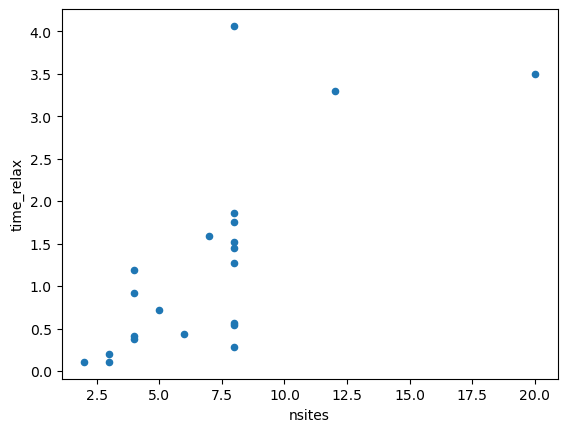

In [18]:
ax = df.plot(x="nsites", y="time_relax", kind="scatter")

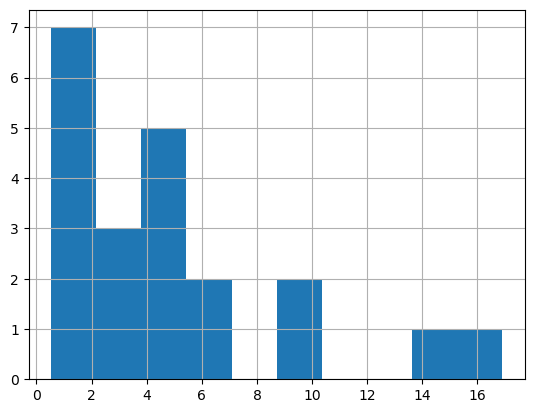

In [23]:
ax = df["time_total"].hist()